# Hoda Reader

In [ ]:
# Hoda Dataset Reader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Preprocess

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
# from HodaDataset.HodaDatasetReader import read_hoda_cdb, read_hoda_dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import cv2 as cv
from skimage.feature import local_binary_pattern, hog
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
#
def draw_confusion_matrix(y_true, y_pred, classes=None, normalize=True, title=None, cmap=plt.cm.Blues):
    acc = np.sum(y_true == y_pred) / len(y_true)
    print('Accuracy = {}'.format(acc))

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion Matrix = \n{}'.format(np.round(cm, 3)))

    if classes is None:
        classes = [str(i) for i in range(len(np.unique(y_true)))]

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    print('\n')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

unique heights: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
unique widths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51]


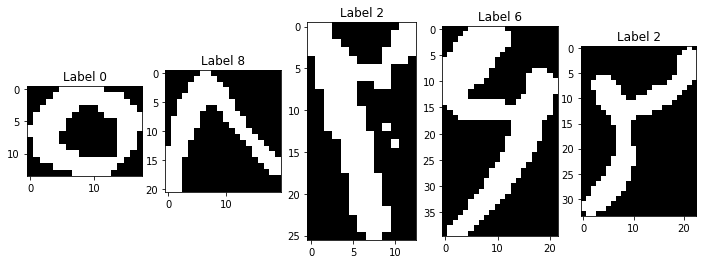

In [5]:
# Load Hoda Farsi Digit Dataset
train_images, train_labels = read_hoda_cdb('/content/drive/My Drive/vision/Train 60000.cdb')
test_images, test_labels = read_hoda_cdb('/content/drive/My Drive/vision/Test 20000.cdb')

# Randomly sample images
import random
plt.figure(figsize=(12,4))
for i, index in enumerate(random.sample(list(range(len(train_images))), 5)):
    plt.subplot(1,5,i+1)
    plt.imshow(train_images[index], cmap='gray', interpolation='none')
    plt.title("Label {}".format(train_labels[index]))

unique_heights = list(set([m.shape[0] for m in train_images]))
print("unique heights:", unique_heights)

unique_widths = list(set([m.shape[1] for m in train_images]))
print("unique widths:", unique_widths)

In [ ]:
def fit_and_resize_image(src_images, dst_image_size):
  X = []
  for i, image in enumerate(src_images):
        X.append(np.array(cv.resize(image, (dst_image_size,dst_image_size), interpolation = cv.INTER_AREA)))
  return X

train_img = fit_and_resize_image(train_images, 32)
test_img = fit_and_resize_image(test_images, 32)

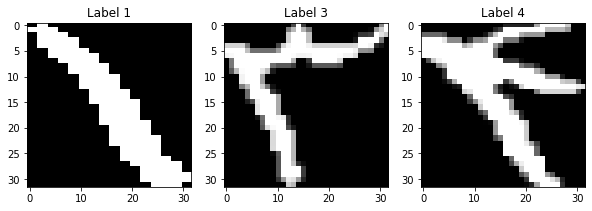

In [8]:
plt.figure(figsize=(10,4))
for i, index in enumerate(random.sample(list(range(len(train_img))), 3)):
    plt.subplot(1,3,i+1)
    plt.imshow(train_img[index], cmap='gray', interpolation='none')
    plt.title("Label {}".format(train_labels[index]))

# Features

***---***

##### train_img, test_img, train_labels, test_labels

***---***

In [ ]:

def extract_geometrical_features(images):
    features = np.zeros((len(images), 3))
    for i in range(len(images)):
        img = images[i]
        ret,thresh = cv.threshold(img,127,255,0)
        contours, hierarchy = cv.findContours(thresh, 1, 2)
        cnt = contours[0]
        for i in range(len(contours) - 1):
          cnt = np.concatenate((cnt, contours[i+1]), axis = 0)
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt,True)
        hull = cv.convexHull(cnt)
        (x,y),(MA,ma),angle = cv.fitEllipse(cnt)
        area_hull = cv.contourArea(hull)
        features[i, 0] = (4 * np.pi * area) / np.square(perimeter) ## compactness
        features[i, 1] = area / area_hull ## solidity
        features[i, 2] = ecce = np.sqrt(1 - np.square(MA / ma)) ## eccentricity
    preProcess = preprocessing.StandardScaler().fit(features)
    features = preProcess.transform(features)
    return features



def extract_textural_features(images):
    # HOG and LBP
    list_hog = []
    list_lbp = []
    for feature in images:
      fd = hog(feature, orientations=9, pixels_per_cell=(8,8),cells_per_block=(3,3))
      list_hog.append(fd)

      out = local_binary_pattern(feature, P=8, R=1)
      hist, aa = np.histogram(out, bins=256)
      list_lbp.append(hist)

    hog_features = np.array(list_hog, 'float64')
    lbp_features = np.array(list_lbp, 'float64')

    preProcess_hog = preprocessing.MaxAbsScaler().fit(hog_features)
    features_hog = preProcess_hog.transform(hog_features)

    preProcess_lbp = preprocessing.MaxAbsScaler().fit(lbp_features)
    features_lbp = preProcess_lbp.transform(lbp_features)

    return features_hog, features_lbp

In [ ]:
#Gabor
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

# ref_feats = np.zeros((len(train_img), len(kernels), 2), dtype=np.double)
# for i in range(len(train_img)):
#   ref_feats[i, :, :] = compute_feats(train_img[i], kernels)
  
# test_feats = np.zeros((20000, len(kernels), 2), dtype=np.double)
# for i in range(len(test_img)):
#   test_feats[i, :, :] = compute_feats(test_img[i], kernels)

In [ ]:
all_data = train_img + test_img
## geometric features
geo = extract_geometrical_features(np.array(all_data))
geo_train_features = geo[:60000]
geo_test_features = geo[60000:]

## texture features
hg, lbp = extract_textural_features(np.array(all_data))
hg_train_features = hg[:60000]
hg_test_features = hg[60000:]
lbp_train_features = lbp[:60000]
lbp_test_features = lbp[60000:]
tx_train_features = np.concatenate((hg_train_features, lbp_train_features), axis=1)
tx_test_features = np.concatenate((hg_test_features, lbp_test_features), axis=1)

## Train, Test and Evaluation

## geometric features

### hyper parameter

In [15]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(geo_train_features, train_labels)
print(clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

{'C': 10, 'kernel': 'rbf'}


In [18]:
parameters = {'n_neighbors':(3, 5, 7)}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(geo_train_features, train_labels)
print(clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 7}


### models

Accuracy = 0.365
Confusion Matrix = 
[[0.176 0.116 0.    0.002 0.056 0.65  0.    0.    0.    0.   ]
 [0.051 0.932 0.    0.    0.    0.016 0.    0.002 0.    0.   ]
 [0.054 0.112 0.15  0.043 0.068 0.038 0.03  0.316 0.188 0.   ]
 [0.014 0.014 0.024 0.027 0.329 0.082 0.134 0.274 0.098 0.002]
 [0.016 0.014 0.004 0.01  0.466 0.166 0.168 0.117 0.037 0.003]
 [0.    0.    0.    0.    0.025 0.96  0.011 0.004 0.    0.   ]
 [0.012 0.078 0.028 0.012 0.156 0.093 0.25  0.281 0.089 0.   ]
 [0.004 0.156 0.019 0.006 0.02  0.071 0.038 0.511 0.175 0.   ]
 [0.002 0.152 0.012 0.008 0.034 0.042 0.06  0.511 0.18  0.   ]
 [0.    0.01  0.    0.    0.07  0.838 0.072 0.01  0.002 0.   ]]


Accuracy = 0.4397
Confusion Matrix = 
[[0.246 0.068 0.003 0.009 0.015 0.005 0.006 0.002 0.    0.646]
 [0.045 0.923 0.006 0.    0.    0.    0.002 0.004 0.004 0.016]
 [0.    0.012 0.518 0.088 0.018 0.    0.054 0.158 0.112 0.038]
 [0.002 0.    0.139 0.301 0.198 0.    0.128 0.08  0.061 0.09 ]
 [0.011 0.    0.048 0.222 0.401 0.024 0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy = 0.41195
Confusion Matrix = 
[[0.19  0.096 0.003 0.004 0.057 0.648 0.001 0.    0.    0.002]
 [0.06  0.89  0.01  0.    0.01  0.016 0.008 0.    0.008 0.   ]
 [0.029 0.02  0.447 0.062 0.011 0.038 0.047 0.21  0.136 0.   ]
 [0.01  0.002 0.1   0.157 0.188 0.082 0.246 0.146 0.066 0.002]
 [0.006 0.002 0.034 0.08  0.404 0.15  0.224 0.039 0.024 0.036]
 [0.    0.    0.    0.001 0.025 0.944 0.007 0.    0.    0.022]
 [0.009 0.01  0.113 0.066 0.107 0.092 0.366 0.146 0.086 0.006]
 [0.003 0.02  0.154 0.029 0.005 0.071 0.08  0.244 0.396 0.   ]
 [0.001 0.032 0.098 0.041 0.011 0.042 0.116 0.2   0.46  0.   ]
 [0.    0.004 0.    0.003 0.066 0.828 0.079 0.    0.002 0.018]]


Accuracy = 0.45625
Confusion Matrix = 
[[0.24  0.071 0.005 0.003 0.018 0.65  0.008 0.    0.    0.004]
 [0.062 0.902 0.009 0.    0.    0.016 0.002 0.001 0.007 0.   ]
 [0.    0.012 0.586 0.067 0.007 0.038 0.044 0.082 0.163 0.   ]
 [0.001 0.    0.16  0.285 0.184 0.082 0.147 0.057 0.082 0.002]
 [0.004 0.002 0.046 0.17  0.448 0.136

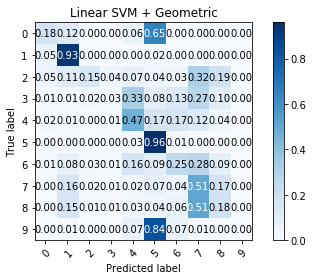

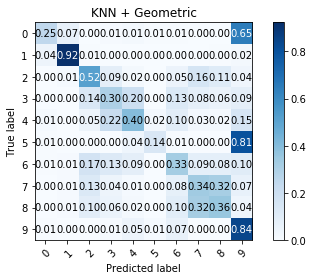

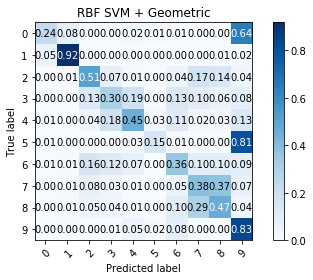

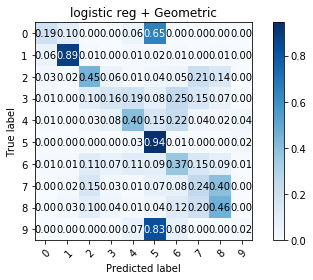

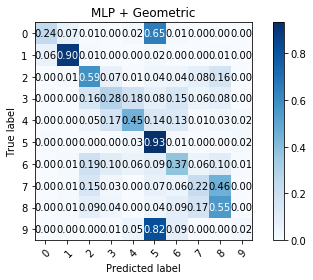

In [21]:
print('Linear SVM + Geometric')
model1 = LinearSVC().fit(geo_train_features, train_labels)
test_predictions_1 = model1.predict(geo_test_features)
draw_confusion_matrix(test_labels, test_predictions_1, title='Linear SVM + Geometric')

print('KNN + Geometric')
model2 = KNeighborsClassifier(n_neighbors=7).fit(geo_train_features, train_labels)
test_predictions_2 = model2.predict(geo_test_features)
draw_confusion_matrix(test_labels, test_predictions_2, title='KNN + Geometric')

print('RBF SVM + Geometric')
model3 = SVC(kernel = 'rbf', gamma = 'scale', C=10).fit(geo_train_features, train_labels)
test_predictions_3 = model3.predict(geo_test_features)
draw_confusion_matrix(test_labels, test_predictions_3, title='RBF SVM + Geometric')

print('logistic reg + Geometric')
model4 = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial').fit(geo_train_features, train_labels)
test_predictions_4 = model4.predict(geo_test_features)
draw_confusion_matrix(test_labels, test_predictions_4, title='logistic reg + Geometric')

print('MLP + Geometric')
model5 = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 100), alpha = 0.3).fit(geo_train_features, train_labels)
test_predictions_5 = model5.predict(geo_test_features)
draw_confusion_matrix(test_labels, test_predictions_5, title='MLP + Geometric')

plt.show()

## HOG

Linear SVM + HOG
Accuracy = 0.9762
Confusion Matrix = 
[[0.961 0.028 0.    0.    0.002 0.006 0.001 0.001 0.    0.001]
 [0.012 0.98  0.    0.    0.002 0.001 0.003 0.    0.    0.001]
 [0.    0.012 0.97  0.008 0.004 0.    0.003 0.001 0.    0.002]
 [0.    0.    0.034 0.95  0.013 0.    0.    0.    0.    0.   ]
 [0.    0.    0.008 0.012 0.974 0.    0.002 0.    0.    0.002]
 [0.006 0.004 0.001 0.    0.004 0.983 0.001 0.    0.002 0.   ]
 [0.    0.002 0.003 0.    0.002 0.002 0.976 0.001 0.    0.013]
 [0.    0.002 0.002 0.    0.    0.    0.004 0.992 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.996 0.002]
 [0.    0.006 0.    0.001 0.    0.    0.01  0.    0.002 0.98 ]]


KNN + HOG
Accuracy = 0.9692
Confusion Matrix = 
[[0.968 0.029 0.    0.    0.    0.003 0.    0.    0.    0.   ]
 [0.02  0.978 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.014 0.967 0.014 0.002 0.    0.    0.001 0.    0.   ]
 [0.001 0.    0.062 0.923 0.011 0.    0.    0.    0.    0.   ]
 [0.002 0.  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy = 0.97595
Confusion Matrix = 
[[0.962 0.027 0.    0.    0.002 0.006 0.002 0.    0.    0.001]
 [0.015 0.978 0.    0.    0.001 0.001 0.002 0.001 0.    0.002]
 [0.    0.005 0.976 0.008 0.005 0.    0.003 0.001 0.    0.002]
 [0.    0.    0.024 0.957 0.017 0.    0.    0.    0.    0.   ]
 [0.    0.002 0.008 0.014 0.972 0.002 0.002 0.    0.    0.001]
 [0.004 0.005 0.    0.    0.003 0.986 0.    0.    0.    0.   ]
 [0.    0.002 0.005 0.001 0.007 0.002 0.97  0.002 0.    0.012]
 [0.    0.003 0.004 0.002 0.    0.    0.004 0.988 0.    0.   ]
 [0.    0.001 0.    0.    0.    0.002 0.    0.    0.996 0.001]
 [0.001 0.006 0.    0.    0.    0.001 0.014 0.    0.002 0.976]]


MLP + HOG
Accuracy = 0.9777
Confusion Matrix = 
[[0.98  0.018 0.    0.    0.    0.001 0.    0.    0.    0.   ]
 [0.024 0.975 0.    0.    0.001 0.    0.    0.    0.    0.   ]
 [0.    0.008 0.968 0.016 0.004 0.    0.    0.002 0.    0.002]
 [0.002 0.    0.02  0.966 0.01  0.    0.    0.    0.    0.001]
 [0.001 0.    0.006 0.018 0.

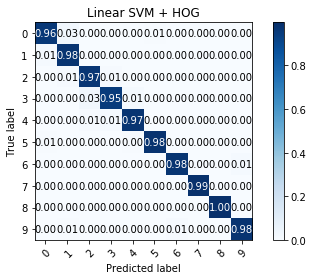

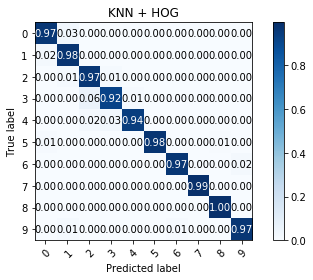

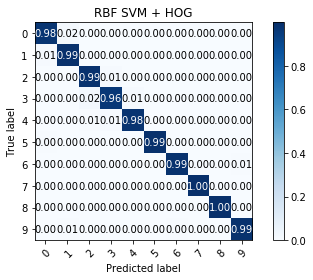

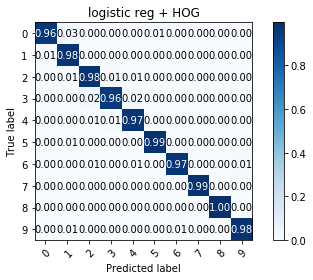

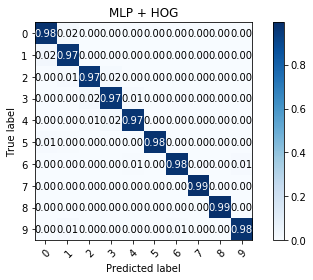

In [23]:
print('Linear SVM + HOG')
model1 = LinearSVC().fit(hg_train_features, train_labels)
test_predictions_1 = model1.predict(hg_test_features)
draw_confusion_matrix(test_labels, test_predictions_1, title='Linear SVM + HOG')

print('KNN + HOG')
model2 = KNeighborsClassifier(n_neighbors=7).fit(hg_train_features, train_labels)
test_predictions_2 = model2.predict(hg_test_features)
draw_confusion_matrix(test_labels, test_predictions_2, title='KNN + HOG')

print('RBF SVM + HOG')
model3 = SVC(kernel = 'rbf', gamma = 'scale', C=10).fit(hg_train_features, train_labels)
test_predictions_3 = model3.predict(hg_test_features)
draw_confusion_matrix(test_labels, test_predictions_3, title='RBF SVM + HOG')

print('logistic reg + HOG')
model4 = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial').fit(hg_train_features, train_labels)
test_predictions_4 = model4.predict(hg_test_features)
draw_confusion_matrix(test_labels, test_predictions_4, title='logistic reg + HOG')

print('MLP + HOG')
model5 = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 100), alpha = 0.3).fit(hg_train_features, train_labels)
test_predictions_5 = model5.predict(hg_test_features)
draw_confusion_matrix(test_labels, test_predictions_5, title='MLP + HOG')

plt.show()

## LBP

Linear SVM + LBP
Accuracy = 0.80325
Confusion Matrix = 
[[0.87  0.072 0.014 0.    0.002 0.016 0.01  0.002 0.    0.012]
 [0.058 0.905 0.014 0.002 0.008 0.    0.008 0.    0.004 0.003]
 [0.02  0.047 0.73  0.048 0.085 0.    0.028 0.007 0.001 0.032]
 [0.009 0.003 0.188 0.522 0.082 0.026 0.026 0.023 0.014 0.107]
 [0.007 0.007 0.078 0.038 0.772 0.008 0.032 0.    0.    0.058]
 [0.01  0.001 0.006 0.004 0.022 0.926 0.002 0.    0.002 0.027]
 [0.018 0.06  0.04  0.055 0.037 0.001 0.734 0.01  0.002 0.042]
 [0.004 0.    0.031 0.018 0.    0.002 0.012 0.878 0.052 0.002]
 [0.006 0.    0.006 0.006 0.001 0.    0.009 0.054 0.915 0.002]
 [0.014 0.02  0.017 0.055 0.064 0.014 0.022 0.    0.014 0.78 ]]


KNN + LBP
Accuracy = 0.75905
Confusion Matrix = 
[[0.946 0.023 0.013 0.006 0.    0.002 0.003 0.002 0.001 0.004]
 [0.03  0.964 0.004 0.    0.001 0.    0.    0.    0.    0.   ]
 [0.018 0.068 0.829 0.034 0.028 0.    0.006 0.006 0.    0.01 ]
 [0.007 0.004 0.39  0.446 0.04  0.004 0.008 0.023 0.02  0.056]
 [0.01  0.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy = 0.8203
Confusion Matrix = 
[[0.876 0.064 0.011 0.002 0.002 0.018 0.009 0.    0.    0.018]
 [0.05  0.904 0.024 0.003 0.004 0.    0.01  0.    0.004 0.001]
 [0.024 0.034 0.758 0.064 0.066 0.    0.032 0.004 0.    0.018]
 [0.012 0.002 0.126 0.65  0.062 0.014 0.026 0.016 0.008 0.084]
 [0.008 0.008 0.064 0.05  0.778 0.009 0.028 0.    0.    0.056]
 [0.006 0.    0.001 0.014 0.02  0.912 0.004 0.001 0.004 0.038]
 [0.02  0.04  0.046 0.05  0.042 0.002 0.766 0.008 0.001 0.026]
 [0.002 0.    0.018 0.03  0.    0.002 0.012 0.884 0.05  0.001]
 [0.004 0.    0.    0.015 0.    0.001 0.006 0.066 0.906 0.001]
 [0.013 0.022 0.017 0.07  0.058 0.012 0.022 0.    0.016 0.768]]


MLP + LBP
Accuracy = 0.87405
Confusion Matrix = 
[[0.92  0.036 0.01  0.002 0.002 0.016 0.002 0.    0.    0.012]
 [0.029 0.95  0.01  0.    0.002 0.    0.004 0.    0.001 0.002]
 [0.01  0.016 0.842 0.054 0.048 0.    0.008 0.006 0.    0.018]
 [0.005 0.    0.127 0.716 0.058 0.012 0.006 0.01  0.005 0.061]
 [0.004 0.001 0.043 0.042 0.

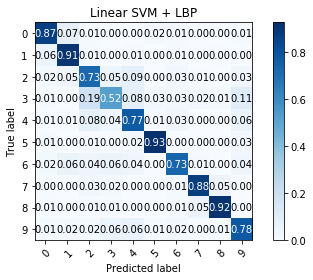

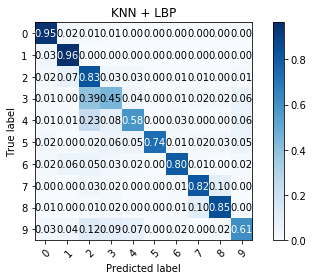

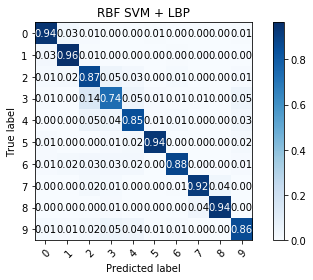

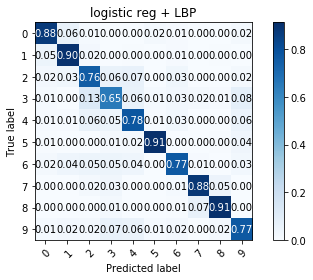

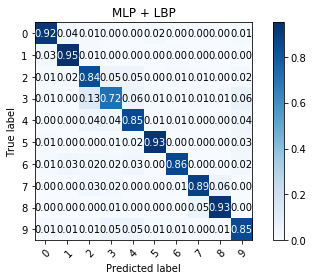

In [24]:
print('Linear SVM + LBP')
model1 = LinearSVC().fit(lbp_train_features, train_labels)
test_predictions_1 = model1.predict(lbp_test_features)
draw_confusion_matrix(test_labels, test_predictions_1, title='Linear SVM + LBP')

print('KNN + LBP')
model2 = KNeighborsClassifier(n_neighbors=7).fit(lbp_train_features, train_labels)
test_predictions_2 = model2.predict(lbp_test_features)
draw_confusion_matrix(test_labels, test_predictions_2, title='KNN + LBP')

print('RBF SVM + LBP')
model3 = SVC(kernel = 'rbf', gamma = 'scale', C=10).fit(lbp_train_features, train_labels)
test_predictions_3 = model3.predict(lbp_test_features)
draw_confusion_matrix(test_labels, test_predictions_3, title='RBF SVM + LBP')

print('logistic reg + LBP')
model4 = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial').fit(lbp_train_features, train_labels)
test_predictions_4 = model4.predict(lbp_test_features)
draw_confusion_matrix(test_labels, test_predictions_4, title='logistic reg + LBP')

print('MLP + LBP')
model5 = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 100), alpha = 0.3).fit(lbp_train_features, train_labels)
test_predictions_5 = model5.predict(lbp_test_features)
draw_confusion_matrix(test_labels, test_predictions_5, title='MLP + LBP')

plt.show()

## textural features

Linear SVM + textural
Accuracy = 0.9806
Confusion Matrix = 
[[0.972 0.02  0.    0.    0.002 0.002 0.002 0.001 0.    0.   ]
 [0.008 0.984 0.    0.    0.002 0.    0.004 0.    0.    0.   ]
 [0.    0.01  0.975 0.006 0.004 0.    0.002 0.001 0.    0.002]
 [0.    0.    0.031 0.954 0.013 0.    0.001 0.    0.    0.   ]
 [0.    0.    0.01  0.008 0.979 0.    0.002 0.001 0.    0.001]
 [0.006 0.001 0.001 0.    0.002 0.988 0.    0.    0.001 0.   ]
 [0.    0.003 0.004 0.    0.003 0.003 0.978 0.    0.    0.01 ]
 [0.    0.001 0.002 0.    0.    0.    0.001 0.994 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.998 0.001]
 [0.001 0.006 0.    0.    0.    0.001 0.006 0.    0.001 0.984]]


KNN + textural
Accuracy = 0.96575
Confusion Matrix = 
[[0.969 0.028 0.    0.    0.    0.003 0.    0.    0.    0.   ]
 [0.021 0.978 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.02  0.965 0.011 0.003 0.    0.    0.    0.    0.001]
 [0.002 0.001 0.072 0.906 0.016 0.    0.001 0.    0.    0.   ]
 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy = 0.97735
Confusion Matrix = 
[[0.969 0.024 0.    0.    0.002 0.004 0.    0.001 0.    0.   ]
 [0.01  0.983 0.002 0.    0.001 0.    0.002 0.    0.    0.001]
 [0.    0.005 0.969 0.012 0.009 0.001 0.001 0.001 0.    0.002]
 [0.    0.    0.028 0.954 0.015 0.    0.001 0.    0.    0.   ]
 [0.    0.002 0.008 0.014 0.968 0.002 0.004 0.001 0.    0.   ]
 [0.003 0.003 0.    0.    0.002 0.99  0.    0.    0.001 0.   ]
 [0.    0.003 0.004 0.002 0.006 0.002 0.976 0.002 0.    0.007]
 [0.    0.002 0.004 0.001 0.    0.    0.002 0.99  0.    0.   ]
 [0.    0.002 0.    0.    0.    0.    0.    0.    0.996 0.   ]
 [0.    0.006 0.    0.    0.    0.001 0.011 0.    0.002 0.978]]


MLP + textural
Accuracy = 0.97965
Confusion Matrix = 
[[0.979 0.018 0.    0.    0.    0.002 0.    0.    0.    0.   ]
 [0.016 0.982 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
 [0.    0.006 0.976 0.009 0.005 0.    0.    0.002 0.    0.002]
 [0.    0.    0.023 0.962 0.012 0.001 0.    0.    0.    0.   ]
 [0.001 0.001 0.008 0.

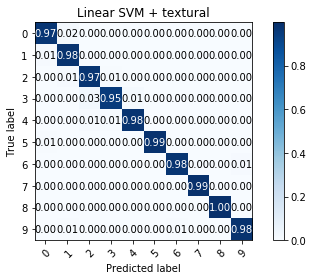

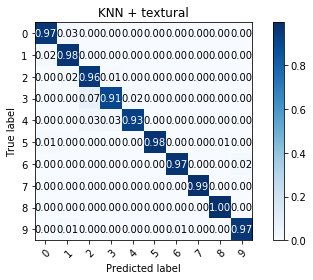

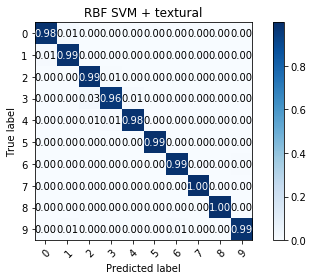

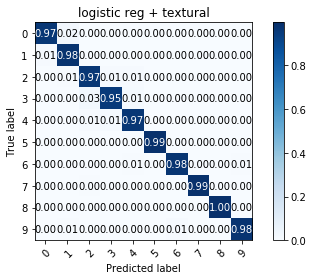

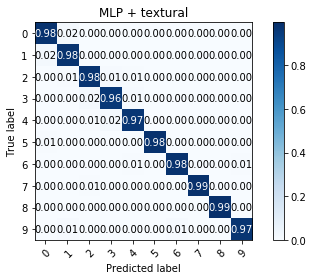

In [25]:
print('Linear SVM + textural')
model1 = LinearSVC().fit(tx_train_features, train_labels)
test_predictions_1 = model1.predict(tx_test_features)
draw_confusion_matrix(test_labels, test_predictions_1, title='Linear SVM + textural')

print('KNN + textural')
model2 = KNeighborsClassifier(n_neighbors=7).fit(tx_train_features, train_labels)
test_predictions_2 = model2.predict(tx_test_features)
draw_confusion_matrix(test_labels, test_predictions_2, title='KNN + textural')

print('RBF SVM + textural')
model3 = SVC(kernel = 'rbf', gamma = 'scale', C=10).fit(tx_train_features, train_labels)
test_predictions_3 = model3.predict(tx_test_features)
draw_confusion_matrix(test_labels, test_predictions_3, title='RBF SVM + textural')

print('logistic reg + textural')
model4 = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial').fit(tx_train_features, train_labels)
test_predictions_4 = model4.predict(tx_test_features)
draw_confusion_matrix(test_labels, test_predictions_4, title='logistic reg + textural')

print('MLP + textural')
model5 = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 100), alpha = 0.3).fit(tx_train_features, train_labels)
test_predictions_5 = model5.predict(tx_test_features)
draw_confusion_matrix(test_labels, test_predictions_5, title='MLP + textural')

plt.show()